In [1]:
import gpjax as gpx
import jax

from jax import config
config.update("jax_enable_x64", True)

In [2]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jr

In [3]:
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

## Show for a single iteration first

In [18]:
ngrid = 500
key = jr.key(1234)

# Construct a grid on [0, 1] to approximate the function
xlim = jnp.linspace(0, 1, ngrid).reshape(-1, 1)

In [19]:
# GP prior
kernel = gpx.kernels.RBF(lengthscale=0.08)  # 1-dimensional input
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
prior_dist = prior.predict(xlim)

In [20]:
# sample a random function
f = prior_dist.sample(seed=key, sample_shape=(1,)).T

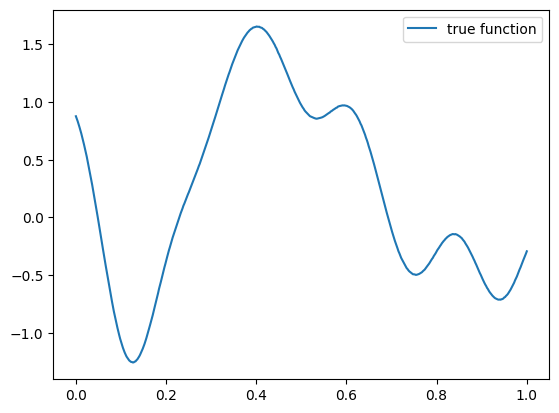

In [21]:
plt.plot(xlim, f, label="true function")
plt.legend()

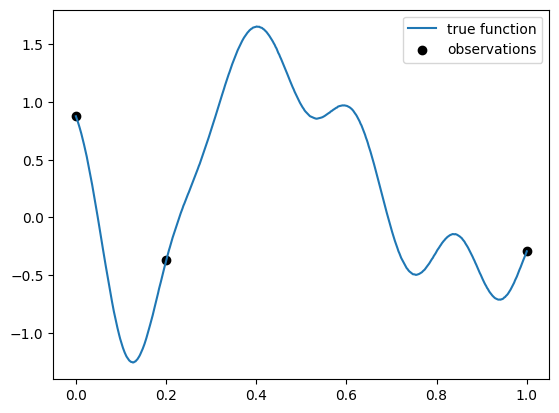

In [22]:
# Suppose we observe the endpoints and a middle point
x = jnp.stack([xlim[0], xlim[100], xlim[-1]])
y = jnp.stack([f[0], f[100], f[-1]])
D = gpx.Dataset(X=x, y=y)

plt.plot(xlim, f, label="true function")

plt.scatter(D.X, D.y, label="observations", c="k")

plt.legend()

In [9]:
len(x)

3

In [23]:
# Computer posterior GP, assume no noise
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=0.)
posterior = prior * likelihood

# in practice need to fit the hyperparameters but here we will use their true value
opt_posterior = posterior

In [24]:
# Compute predictive distribution
latent_dist = opt_posterior.predict(xlim, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

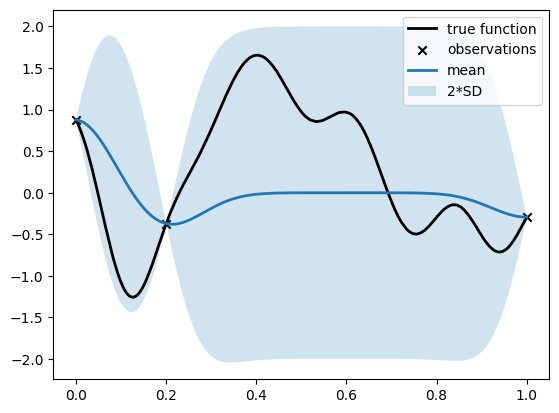

In [25]:
# Plot the posterior predictive distribution at the points on the x-grid
plt.plot(xlim, f, label="true function", c="k", lw=2)

plt.scatter(D.X, D.y, label="observations", c="k", marker="x")

plt.plot(xlim, predictive_mean, c="tab:blue", label="mean", lw=2)
plt.fill_between(xlim.ravel(), predictive_mean - predictive_std*2, predictive_mean + predictive_std*2, alpha=0.2, label="2*SD") 

plt.legend()

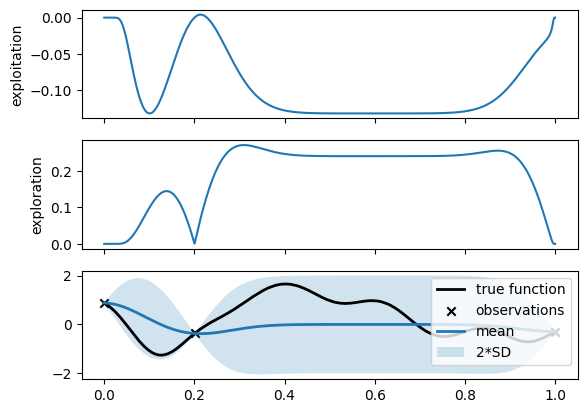

In [26]:
fig, ax = plt.subplots(3, 1, sharex=True)

# compute the minimum w.r.t. observed values
f_star = D.y.min()

# compute first term of EI
EI = (f_star - predictive_mean) * jsp.stats.norm.cdf((f_star - predictive_mean) / predictive_std) 

# plot the contribution of exploit term (low mean)
ax[0].plot(xlim, EI); ax[0].set_ylabel("exploitation")

# compute second term of EI
EI += predictive_std * jsp.stats.norm.pdf((f_star - predictive_mean) / predictive_std) 

# plot the contribution of explore term (high uncertainty)
ax[1].plot(xlim, EI); ax[1].set_ylabel("exploration")


# Plot the posterior predictive distribution at the points on the x-grid
ax[2].plot(xlim, f, label="true function", c="k", lw=2)

ax[2].scatter(D.X, D.y, label="observations", c="k", marker="x")

ax[2].plot(xlim, predictive_mean, c="tab:blue", label="mean", lw=2)
ax[2].fill_between(xlim.ravel(), predictive_mean - predictive_std*2, predictive_mean + predictive_std*2, alpha=0.2, label="2*SD") 

ax[2].legend()

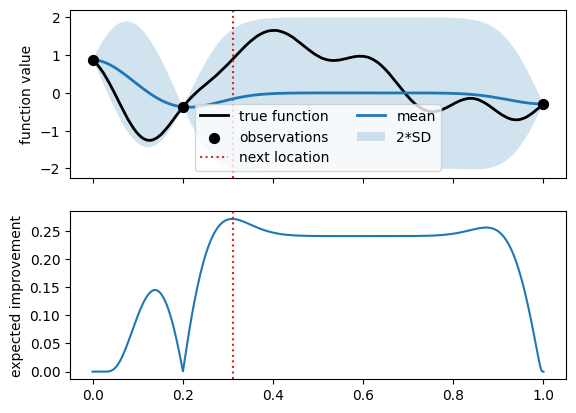

In [27]:
# get the index of the point that maximizes EI
nextx = EI.argmax()

# Plot the posterior predictive distribution at the points on the x-grid
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(xlim, f, label="true function", c="k", lw=2)

ax[0].scatter(x, y, label="observations", c="k", marker="o", s=50, zorder=5)

ax[0].axvline(xlim[nextx], label="next location", c="tab:red", ls="dotted") #, marker="o")


ax[0].plot(xlim, predictive_mean, c="tab:blue", label="mean", lw=2)
ax[0].fill_between(xlim.ravel(), predictive_mean - predictive_std*2, predictive_mean + predictive_std*2, alpha=0.2, label="2*SD") 
ax[0].set_ylabel("function value")

ax[0].legend(ncol=2)

ax[1].plot(xlim, EI)
ax[1].axvline(xlim[nextx], label="next location", c="tab:red", ls="dotted") #, marker="o")

ax[1].set_ylabel("expected improvement")

plt.savefig(f"figs/1D_EI_round_1.png", bbox_inches="tight", dpi=300)

## Run for a few steps

In [28]:
def get_pred_mean_std(D, prior, likelihood, xlim):
    # Computer posterior GP, assume no noise
    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=0.)
    posterior = prior * likelihood

    # in practice need to fit the hyperparameters but here we will use their true value
    opt_posterior = posterior
    
    # Compute predictive distribution
    latent_dist = opt_posterior.predict(xlim, train_data=D)
    predictive_dist = opt_posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()
    
    return predictive_mean, predictive_std


def compute_EI(D, predictive_mean, predictive_std):

    # compute the minimum w.r.t. observed values
    f_star = D.y.min()

    # compute first term of EI
    EI = (f_star - predictive_mean) * jsp.stats.norm.cdf((f_star - predictive_mean) / predictive_std) 

    # plot the contribution of exploit term (low mean)
    #ax[0].plot(xlim, EI); ax[0].set_ylabel("exploitation")

    # compute second term of EI
    EI += predictive_std * jsp.stats.norm.pdf((f_star - predictive_mean) / predictive_std) 

    # plot the contribution of explore term (high uncertainty)
    #ax[1].plot(xlim, EI); ax[1].set_ylabel("exploration")
    
    return EI

In [29]:
nextx

Array(155, dtype=int64)

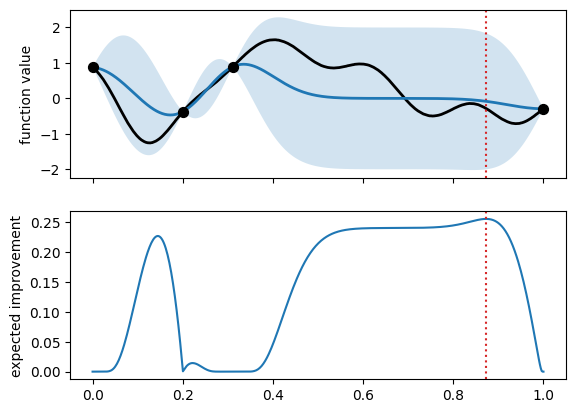

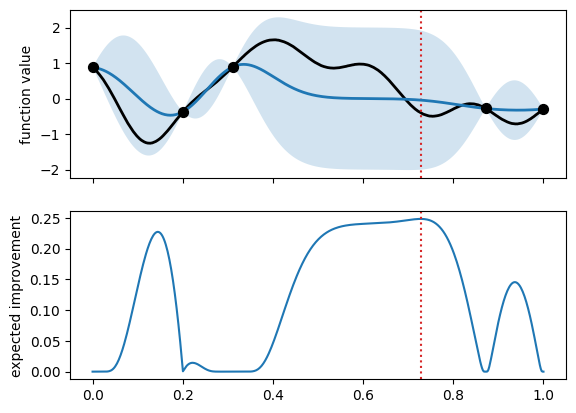

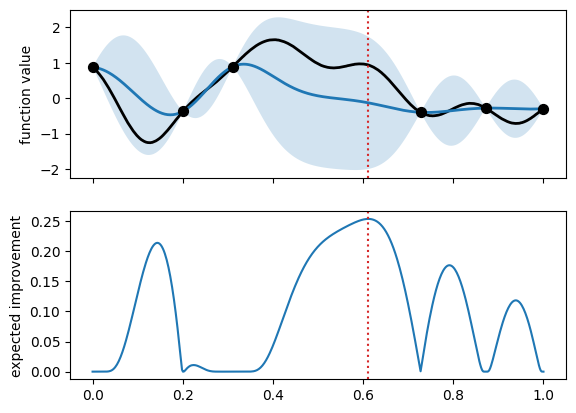

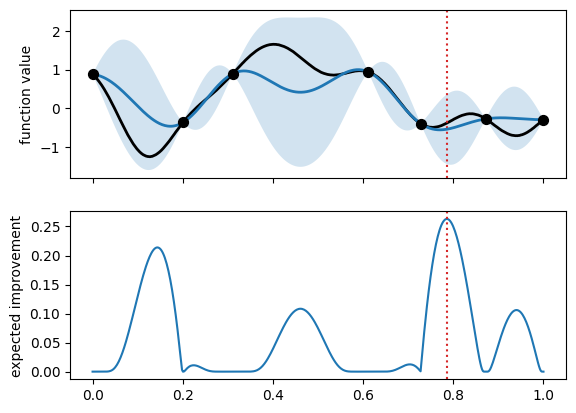

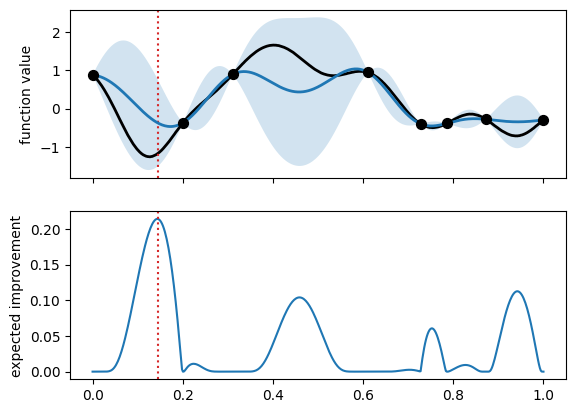

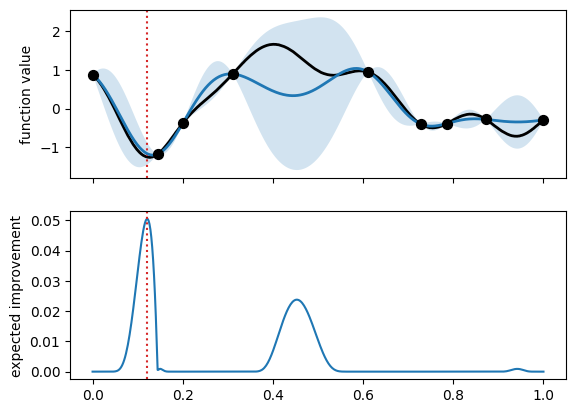

In [30]:
for i in range(2,8):
    # add new x, y to data set
    D.X = jnp.concat([D.X, xlim[nextx].reshape(-1,1)])
    D.y = jnp.concat([D.y, f[nextx].reshape(-1,1)])

    # compute predictive mean
    predictive_mean, predictive_std = get_pred_mean_std(D, prior, likelihood, xlim)

    # compute expected improvement
    EI = compute_EI(D, predictive_mean, predictive_std)
    
    # get the index of the point that maximizes EI
    nextx = EI.argmax()

    # Plot the posterior predictive distribution at the points on the x-grid
    fig, ax = plt.subplots(2, 1, sharex=True)

    ax[0].plot(xlim, f, label="true function", c="k", lw=2)

    ax[0].scatter(D.X, D.y, label="observations", c="k", marker="o", s=50, zorder=5)

    ax[0].axvline(xlim[nextx], label="next location", c="tab:red", ls="dotted") #, marker="o")


    ax[0].plot(xlim, predictive_mean, c="tab:blue", label="mean", lw=2)
    ax[0].fill_between(xlim.ravel(), predictive_mean - predictive_std*2, predictive_mean + predictive_std*2, alpha=0.2, label="2*SD") 
    ax[0].set_ylabel("function value")

    #ax[0].legend(ncol=2)

    ax[1].plot(xlim, EI)
    ax[1].axvline(xlim[nextx], label="next location", c="tab:red", ls="dotted") #, marker="o")

    ax[1].set_ylabel("expected improvement")

    plt.savefig(f"figs/1D_EI_round_{i}.png", bbox_inches="tight", dpi=300)